# Assignment 4 - Blackjack

In [23]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras

Load the environment

In [24]:
env = gym.make("Blackjack-v1", sab=False)

In [25]:
observation, info = env.reset()
print(observation)
print("Observation shape:", np.array(observation).shape)

(20, 10, 0)
Observation shape: (3,)


Define a policy

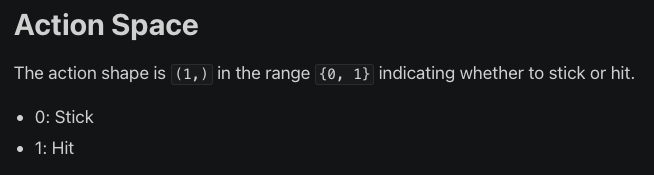

In [26]:
def define_policy(observation):
    return 0 if observation[0] >= 17 else 1

Simple policy impl:

In [27]:
num_episodes = 1000
wins = 0

for i in range(num_episodes):
    observation, info = env.reset()
    while True:
        action = define_policy(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            wins += 1 if reward > 0 else 0
            break

print(f"Win rate :{wins/num_episodes * 100:.2f}%")

Win rate :39.40%


DEEP Q-Learning

In [28]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt

In [29]:
class BlackjackAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=2000, batch_size=32):
        self.state_size = state_size
        self.action_size = action_size
        self.discount_factor = discount_factor  
        self.epsilon = epsilon  #Exploration rate
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.memory = deque(maxlen=memory_size) #A fixed number of experience replays (when over, the oldest is removed)

        self.q_network = self.build_model()
        self.target_q_network = self.build_model()
        self.update_target_network()

    def build_model(self):
        """Q-value network that is replacing the Q-table"""
        model = keras.Sequential()
        model.add(keras.layers.Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(keras.layers.Dense(32, activation='relu'))
        model.add(keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model
    
    def update_target_network(self):
        self.target_q_network.set_weights(self.q_network.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)  # Explore
        state = np.expand_dims(state, axis=0)
        q_values = self.q_network.predict(state, verbose=0)
        return np.argmax(q_values[0])  # Exploit
    
    def train_from_replay(self):
        """The function uses experience replay to train the Q-network, stabilizing the learning process by using a random sample of past experiences. The target represents the expected return for a given state-action pair, helping the network to learn the optimal policy."""
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = np.expand_dims(next_state, axis=0)
                target += self.discount_factor * np.max(self.target_q_network.predict(next_state, verbose=0)[0])
            
            state = np.expand_dims(state, axis=0)
            target_q = self.q_network.predict(state, verbose=0)
            target_q[0][action] = target
            
            self.q_network.fit(state, target_q, epochs=1, verbose=0)

        # Reduce exploration rate so that the agent uses more exxplioited knowledge from the Q-network
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
    


In [30]:
def train_agent(episodes=1000, update_target_frequency=10, learning_rate=0.001, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=2000, batch_size=32):
    env = gym.make('Blackjack-v1', sab=True)
    state_size = 3  # (player_sum, dealer_card, usable_ace)
    action_size = env.action_space.n  # Two actions: stick (0) or hit (1)
    agent = BlackjackAgent(state_size, action_size, learning_rate, discount_factor, epsilon, epsilon_decay, min_epsilon, memory_size, batch_size)
    win_count = 0

    win_rates = []

    for episode in range(episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)

            if terminated or truncated:
                done = True

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

        if total_reward > 0:
            win_count += 1

        agent.train_from_replay()

        # Update target model
        if episode % update_target_frequency == 0:
            agent.update_target_network()

        #print win rate stats every 50 games    
        if (episode + 1) % 50 == 0:
            win_rate = win_count / (episode + 1)
            win_rates.append(win_rate)
            print(f"Episode {episode + 1}, Win Rate: {win_rate:.2f}, Epsilon: {agent.epsilon:.2f}")

    return agent, win_rates

In [31]:
def visualize_dqn_results(agent, win_rates):
    # Plot win rate over episodes
    plt.figure(figsize=(12, 5))
    plt.plot(range(100, len(win_rates) * 100 + 1, 100), win_rates, label='Win Rate')
    plt.xlabel('Episodes')
    plt.ylabel('Win Rate')
    plt.title('Win Rate Over Time')
    plt.legend()
    plt.show()

    # Plot Q-values for a specific state
    state = np.array([18, 6, 1], dtype=np.float32)  # Example state
    q_values = agent.q_network.predict(np.expand_dims(state, axis=0), verbose=0)[0]
    actions = ['Stick', 'Hit']

    plt.figure(figsize=(8, 5))
    plt.bar(actions, q_values, color=['blue', 'orange'])
    plt.xlabel('Action')
    plt.ylabel('Q-Value')
    plt.title(f'Q-Values for State {state.tolist()}')
    plt.show()


In [32]:
agent, win_rates = train_agent(episodes=1000, learning_rate=0.1, batch_size=32)

Episode 50, Win Rate: 0.18, Epsilon: 0.86
Episode 100, Win Rate: 0.20, Epsilon: 0.67
Episode 150, Win Rate: 0.21, Epsilon: 0.52
Episode 200, Win Rate: 0.22, Epsilon: 0.40
Episode 250, Win Rate: 0.23, Epsilon: 0.31
Episode 300, Win Rate: 0.25, Epsilon: 0.24
Episode 350, Win Rate: 0.27, Epsilon: 0.19
Episode 400, Win Rate: 0.28, Epsilon: 0.15
Episode 450, Win Rate: 0.29, Epsilon: 0.12
Episode 500, Win Rate: 0.30, Epsilon: 0.09
Episode 550, Win Rate: 0.30, Epsilon: 0.07
Episode 600, Win Rate: 0.30, Epsilon: 0.05
Episode 650, Win Rate: 0.31, Epsilon: 0.04
Episode 700, Win Rate: 0.32, Epsilon: 0.03
Episode 750, Win Rate: 0.32, Epsilon: 0.03
Episode 800, Win Rate: 0.32, Epsilon: 0.02
Episode 850, Win Rate: 0.32, Epsilon: 0.02
Episode 900, Win Rate: 0.32, Epsilon: 0.01
Episode 950, Win Rate: 0.33, Epsilon: 0.01
Episode 1000, Win Rate: 0.33, Epsilon: 0.01


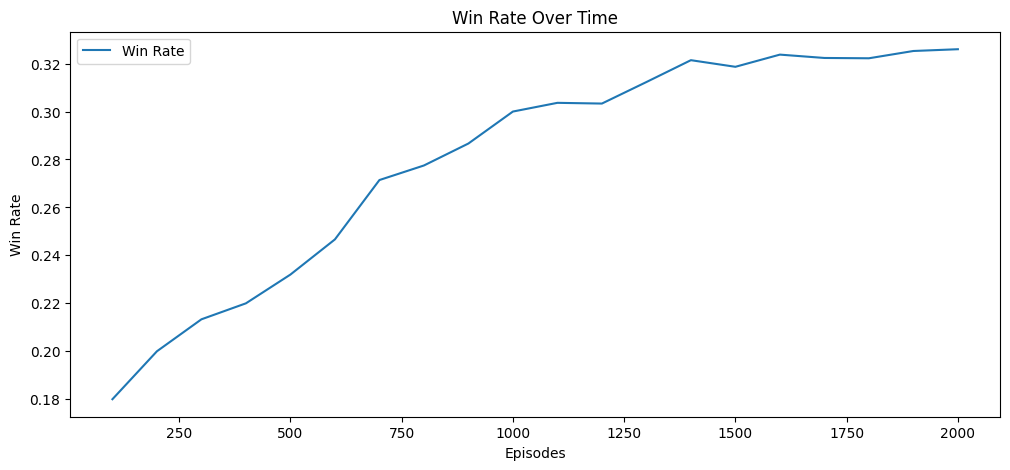

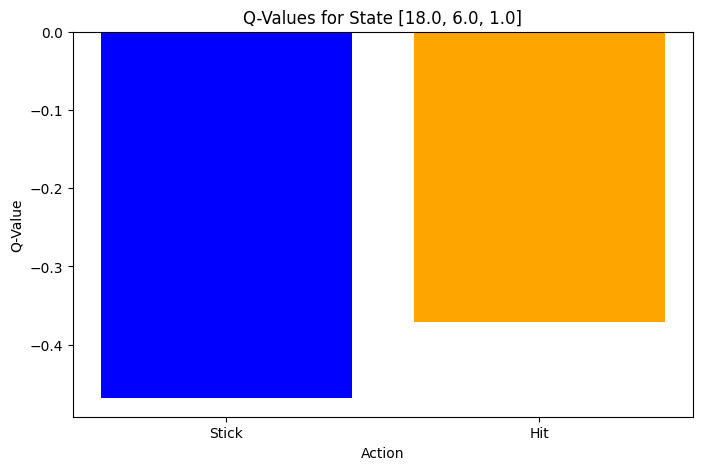

In [34]:
visualize_dqn_results(agent, win_rates)